In [ ]:
# !pip install gdown --upgrade
# !pip install torchinfo
# !pip install torchviz
# !pip install wandb
# !pip install opencv-python

In [13]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.transforms as transforms

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
# from torchinfo import summary
from tqdm.notebook import tqdm
import scipy.signal as sig
import cv2

# torch.__version__ # 1.10.0+cu111

In [ ]:
!wandb login

In [ ]:
wandb.login()

In [4]:
# ! gdown --fuzzy https://drive.google.com/file/d/1iVah8T28-ib5YJUIyjI-sSbD7DiEfkuV/view?usp=share_link

In [5]:
# !unzip /content/uwb-pose-prediction.zip

In [14]:
annot_df = pd.read_csv('annotations.csv')
annot_df

,id,class
0,80a8dc1d-b216-469c-91b1-fc257562a883,0
1,3ab012da-927a-40d6-95f8-5a2f96dad360,0
2,eef92f84-5127-4063-a4a2-fee4035b1ac7,0
3,8d562739-6502-4a6c-8b83-e029b795f685,0
4,404c2e92-1101-4e62-83bf-a6fdb7dfcb9a,0
...,...,...
641,ea5513a7-f18a-4393-8ab4-44e574e70f2b,4
642,edf4aec3-410d-4ed3-90d2-12671bb4c625,4
643,297e1f02-66ac-4e4e-849a-da2f1103e8a0,4
644,926418bb-2e66-4c82-82b1-13a82faf73b4,4


In [15]:
class_df = pd.read_csv('classes.csv')
class_df

,id,class
0,0,ล้ม (เป็นลม/สะดุด)
1,1,กระโดด
2,2,(ตั้งใจ) ลงไปนอนบนที่นอน
3,3,วิ่ง
4,4,จากยืน/เดินลงไปนั่ง
5,5,จากนั่งลุกขึ้นมายืน/เดิน
6,6,เดิน


In [16]:
#Range time data
def range_time(IQ_data, overlap = 1): 
    n_rd_history = 256
    frame = []
    frames = []
    overlap_count = 0
    check = 0
    for iqini in IQ_data:
        if len(frame)<n_rd_history:
            frame.append(iqini)
        else:  
            if check == 0:
                frame1 = np.array(frame)
                frames.append(np.copy(frame1))
                check = 1

            if overlap_count < overlap:
                frame.append(iqini)
                overlap_count = overlap_count+1

            if overlap_count == overlap:
                frame = frame[overlap_count::]
                frame1 = np.array(frame)
                frames.append(np.copy(frame1))
                overlap_count = 0
    return np.stack(frames)

import scipy.fftpack as fft
#Range frequency data
def range_frequency(datas):
    Range_frequency_frame = []
    for data in datas:
        jitter = 1e-10
        # noise_threshold = -65
        dB = True
        #rd_history = np.hanning(n_rd_history)[:, None] * np.array(data)
        # Range-Doppler
        rd = fft.fft(data, axis=0)
        rd = fft.fftshift(rd, axes=0)
        rd = abs(rd)
        if dB:
            rd = 20 * np.log10(rd+jitter)
            # rd[rd < noise_threshold] = noise_threshold
        Range_frequency_frame.append(rd)
    return np.stack(Range_frequency_frame)

def get_time_img(data):
    # output = np.load(f'{data_path}{data_id}')
    output = np.abs(range_time(data, overlap=256))
    return output.reshape(1,1,-1,56)

def get_freq_img(data):
    # output = np.load(f'{data_path}{data_id}')
    output = range_time(data, overlap=256)
    output = range_frequency(output)
    return output.reshape(1,1,-1,56)

In [17]:
def backgroud_suppression(image_array):#60
    image_array = image_array.reshape(1,-1,56)
    _, threshold = cv2.threshold(image_array, -60, 255, cv2.THRESH_BINARY)
    return threshold.reshape(1,1,-1,56)

def apply_low_pass_filter(signal, order=4, cutoff=0.1):
    # Design a low-pass filter
    b, a = sig.butter(order, cutoff)

    # Apply the filter to the signal
    filtered_signal = sig.filtfilt(b, a, signal)

    return filtered_signal

def image_tensor(numpy_array):
    resize = transforms.Resize((256,256))
    return resize(torch.tensor(numpy_array.copy())).permute(1, 2, 0)

In [18]:
tmp = get_freq_img(np.load('train/train/001b0660-4c6e-4d07-8cd5-cd63578512f7.npy'))
# tmp -= tmp.mean(axis=2)
# print(tmp.shape)
# tmp = apply_low_pass_filter(tmp, order=4, cutoff=0.1)
# print(tmp.shape)
# tmp = backgroud_suppression(tmp)
# print(tmp.shape)
plt.imshow(image_tensor(tmp[0]))

NameError: name 'transforms' is not defined

In [19]:
tmp = get_freq_img(np.load('train/train/001b0660-4c6e-4d07-8cd5-cd63578512f7.npy'))
tmp -= tmp.mean(axis=2)
# print(tmp.shape)
# tmp = apply_low_pass_filter(tmp, order=4, cutoff=0.1)
# print(tmp.shape)
# tmp = backgroud_suppression(tmp)
# print(tmp.shape)
plt.imshow(image_tensor(tmp[0]))

NameError: name 'transforms' is not defined

In [20]:
from pandas.core.common import random_state
def train_test_split_df(df, test_size=0.1):
    test_df = df.sample(frac = test_size, random_state = 42)
    train_df = df.drop(test_df.index)
    return train_df, test_df

In [21]:
train_df, val_df = train_test_split_df(annot_df, test_size=0.2)
print(train_df.shape, val_df.shape)

(517, 2) (129, 2)


Text(0, 0.5, 'Counts')

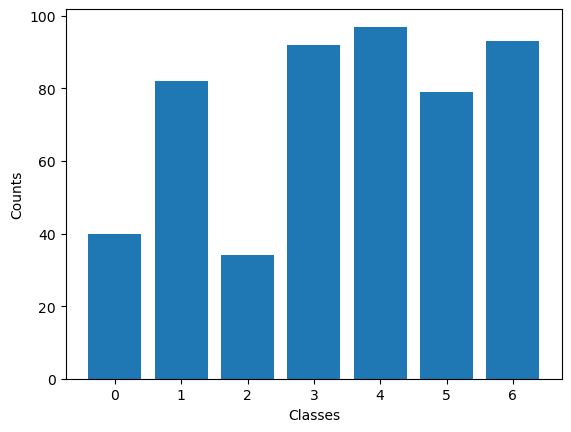

In [43]:
plt.bar(train_df['class'].value_counts().index, height=train_df['class'].value_counts().values)
plt.xlabel('Classes')
plt.ylabel('Counts')

<BarContainer object of 7 artists>

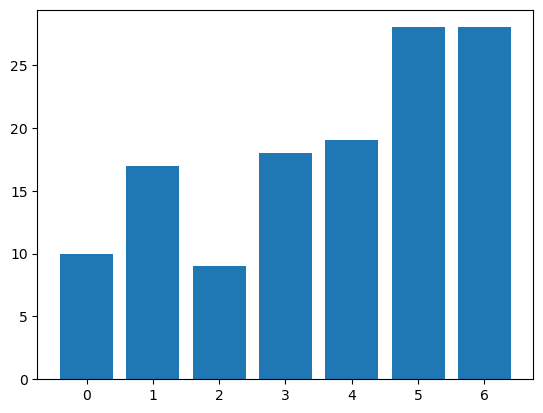

In [23]:
plt.bar(val_df['class'].value_counts().index, height=val_df['class'].value_counts().values)

In [24]:
def read_data(df, main_path='train/train/'):
    # features = np.array([], dtype=np.float32).reshape(1,2560,56)
    # labels = np.array([], dtype=np.float32)
    features = np.empty((0,1,2560,56))
    labels = np.array([], dtype=np.float32)
    for i in tqdm(range(len(df))):
        feature_tmp = np.load(f"{main_path}{df.iloc[i]['id']}.npy")
        if feature_tmp.shape != (2560,56):
            continue
        feature_tmp = get_freq_img(feature_tmp)
        feature_tmp -= feature_tmp.mean(axis=2)
        # feature_tmp = get_freq_img(feature_tmp)
        # feature_tmp = apply_low_pass_filter(feature_tmp, order=4, cutoff=0.1)
        # feature_tmp = backgroud_suppression(feature_tmp)
        # feature_tmp /= 255
        features = np.concatenate((features, feature_tmp), axis=0)
        labels = np.concatenate((labels, df.iloc[i]['class'].reshape(1)), axis=0)

    return features, labels

In [25]:
from imblearn.over_sampling import SMOTE

x_train, y_train = read_data(train_df)
x_val, y_val = read_data(val_df)

train_size = x_train.shape[0]
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train.reshape(train_size,-1),y_train)

train_size = x_train.shape[0]
x_train = x_train.reshape(train_size, 1, -1, 56)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

  0%|          | 0/517 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

(679, 1, 2560, 56) (679,)
(129, 1, 2560, 56) (129,)


In [39]:
np.array(pd.DataFrame(y_train).value_counts().index)

array([(0.0,), (1.0,), (2.0,), (3.0,), (4.0,), (5.0,), (6.0,)],
      dtype=object)

Text(0, 0.5, 'Counts')

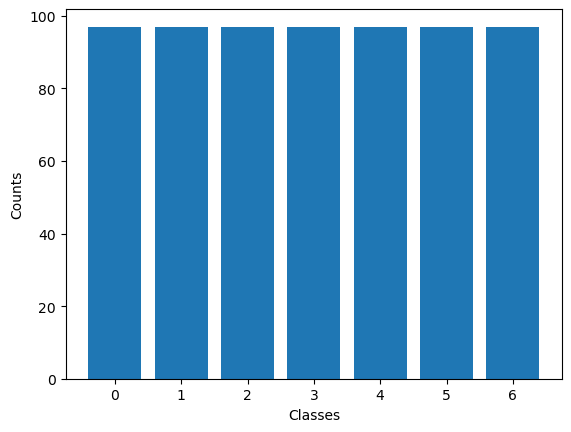

In [44]:
plt.bar(np.array(range(7)), height=pd.DataFrame(y_train).value_counts().values)
plt.xlabel('Classes')
plt.ylabel('Counts')

In [ ]:
plt.bar(train_df['class'].value_counts().index, height=train_df['class'].value_counts().values)

In [20]:
class UWBDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve feature data
        resize = transforms.Resize((256,256))
        x = resize(torch.tensor(x))
        y = self.y[index] # Retrieve target
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [21]:
train_dataset = UWBDataset(x_train, y_train)
val_dataset = UWBDataset(x_val, y_val)

(679, 1, 2560, 56)
(679,)
(129, 1, 2560, 56)
(129,)


In [22]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, pin_memory=True)

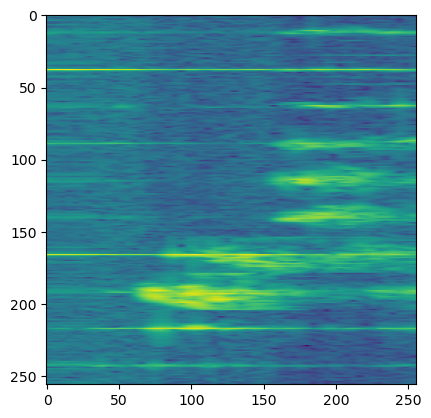

In [23]:
resize = transforms.Resize((256,256))
plt.imshow(resize(torch.tensor(x_train[0])).permute(1, 2, 0))
plt.show()

torch.Size([4, 1, 256, 256])


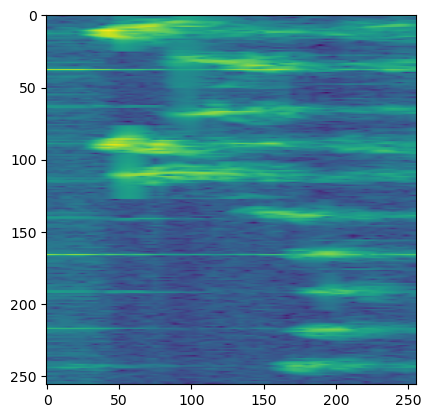

In [24]:
for i in train_loader:
    print(i[0].shape)
    plt.imshow(i[0][0].permute(1, 2, 0))
    break

In [ ]:
# !pip install timm

In [ ]:
# !pip install torchinfo

In [25]:
import timm
import os
from torchinfo import summary
# os.mkdir('/kaggle/working/output')

In [26]:
def create_model(model_name, pretrained = True, num_classes=7):
    model = timm.create_model(model_name, pretrained = pretrained, num_classes = num_classes)
    return model

In [27]:
def search_model(name):
    for model_name in timm.list_models():
        if name in model_name:
            print(model_name)

In [ ]:
####################################################### List of model #######################################################
name = 'efficientnetv2'
search_model(name)

In [28]:
model_name = 'efficientnetv2_s'

model = timm.create_model(model_name, pretrained=True, num_classes=7)
summary(model)

No pretrained weights exist or were found for this model. Using random initialization.


Layer (type:depth-idx)                        Param #
EfficientNet                                  --
├─Conv2d: 1-1                                 648
├─BatchNormAct2d: 1-2                         48
│    └─Identity: 2-1                          --
│    └─SiLU: 2-2                              --
├─Sequential: 1-3                             --
│    └─Sequential: 2-3                        --
│    │    └─ConvBnAct: 3-1                    5,232
│    │    └─ConvBnAct: 3-2                    5,232
│    └─Sequential: 2-4                        --
│    │    └─EdgeResidual: 3-3                 25,632
│    │    └─EdgeResidual: 3-4                 92,640
│    │    └─EdgeResidual: 3-5                 92,640
│    │    └─EdgeResidual: 3-6                 92,640
│    └─Sequential: 2-5                        --
│    │    └─EdgeResidual: 3-7                 95,744
│    │    └─EdgeResidual: 3-8                 164,480
│    │    └─EdgeResidual: 3-9                 164,480
│    │    └─EdgeResidual: 3

In [38]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=7)
        self.model.conv_stem = torch.nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])
        self.dropout = torch.nn.Dropout(0.5)
        self.clf = torch.nn.Linear(in_features=1280, out_features=7, bias=True)
        
#         layer_count = 0
#         for i in model.children():
#             # print(i)
#             for param in i.parameters():
#                 # print(param.requires_grad)
#                 layer_count += 1
                
#         # Freeze some layers
#         frz_layer_count = 0
#         max_frz_layer = int(layer_count * 0.3)
#         print(f'Frozen layers: {max_frz_layer}/{layer_count}')
        
#         for i in self.model.children():
#             for param in i.parameters():
#                 if frz_layer_count <= max_frz_layer:
#                     param.requires_grad = False
#                     frz_layer_count += 1
        
    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        x = self.clf(x)
        # x = nn.Softmax(dim=1)(x) # Softmax layer added to output
        return x

In [39]:
model = MyModel()

No pretrained weights exist or were found for this model. Using random initialization.


In [40]:
summary(model)

Layer (type:depth-idx)                             Param #
MyModel                                            --
├─Sequential: 1-1                                  --
│    └─Conv2d: 2-1                                 216
│    └─BatchNormAct2d: 2-2                         48
│    │    └─Identity: 3-1                          --
│    │    └─SiLU: 3-2                              --
│    └─Sequential: 2-3                             --
│    │    └─Sequential: 3-3                        10,464
│    │    └─Sequential: 3-4                        303,552
│    │    └─Sequential: 3-5                        589,184
│    │    └─Sequential: 3-6                        917,680
│    │    └─Sequential: 3-7                        3,463,840
│    │    └─Sequential: 3-8                        14,561,832
│    └─Conv2d: 2-4                                 327,680
│    └─BatchNormAct2d: 2-5                         2,560
│    │    └─Identity: 3-9                          --
│    │    └─SiLU: 3-10            

In [41]:
model = model.cuda()

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
run_name = f'{model_name}_frz0.3_drop0.5_freq_bgsup_01'
result_path = f'results/{run_name}'
if not os.path.exists(result_path):
    os.mkdir(result_path)

config = {
    'architecture': model_name,
    'lr': 1e-2,
    'scheduler_factor': 0.2,
    'scheduler_patience': 5,
    'early_stop_patience' : 15,
    'scheduler_min_lr': 1e-4,
    'epochs': 200,
    'batch_size': 16,
    'model_path': f'results/{run_name}/model.pth.tar',
    'best_model_path': f'results/{run_name}/best_model.pth'
}

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

# Model
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

In [44]:
train_losses = []
val_losses = []
val_acc_log = []
learning_rates = []
loss_fn = nn.CrossEntropyLoss()
early_stop_counter = 0
best_val_loss = np.inf

# Start wandb run
wandb.init(
    project=run_name,
    config=config,
)

# Log parameters and gradients
wandb.watch(model, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times
    
    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)
        y_true = y_true.to(torch.int64)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()
        
        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)
        
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")
    
    # Validation
    model.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        val_correct = 0
        val_total = 0
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)
            y_true = y_true.to(torch.int64)
            
            # Predict
            y_pred = model(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)
            
            # Calculate accuracy score
            _, val_pred = torch.max(y_pred.data, 1)
            val_total += y_true.size(0)
            val_correct += (val_pred == y_true).sum().item()
            val_acc = val_correct / val_total

            # Log stuff
            val_loss.append(loss)
        
        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f} val accuracy: {val_acc:.4}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'val_acc': val_acc,
                'best_val_loss': best_val_loss,
            }
            
            print(f"Saving new best model..")
            torch.save(state, config['model_path'])

    # Check for early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), config['best_model_path'])  # save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter == config['early_stop_patience']:
            print(f'Early stopping at epoch {epoch}')
            break
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

Training epoch 1...
Current LR: 0.01


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1 train loss: 2.1199
Validating epoch 1


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1 val loss: 3.2109 val accuracy: 0.07752
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 2 train loss: 1.5710
Validating epoch 2


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 val loss: 1.5203 val accuracy: 0.4031
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 3 train loss: 1.3602
Validating epoch 3


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 val loss: 1.5902 val accuracy: 0.3566
Training epoch 4...
Current LR: 0.01


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 4 train loss: 1.2570
Validating epoch 4


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4 val loss: 1.7384 val accuracy: 0.3876
Training epoch 5...
Current LR: 0.01


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 5 train loss: 1.1645
Validating epoch 5


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5 val loss: 4.5431 val accuracy: 0.1705
Training epoch 6...
Current LR: 0.01


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 6 train loss: 1.0981
Validating epoch 6


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6111 val accuracy: 0.4574
Training epoch 7...
Current LR: 0.01


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 7 train loss: 1.0649
Validating epoch 7


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7 val loss: 1.8830 val accuracy: 0.3798
Training epoch 8...
Current LR: 0.01


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 8 train loss: 1.0470
Validating epoch 8


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8 val loss: 1.5958 val accuracy: 0.4574
Training epoch 9...
Current LR: 0.002


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 9 train loss: 0.8012
Validating epoch 9


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9 val loss: 0.9390 val accuracy: 0.6279
Saving new best model..
Training epoch 10...
Current LR: 0.002


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 10 train loss: 0.6149
Validating epoch 10


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10 val loss: 0.8556 val accuracy: 0.6512
Saving new best model..
Training epoch 11...
Current LR: 0.002


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 11 train loss: 0.6662
Validating epoch 11


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11 val loss: 1.0414 val accuracy: 0.5814
Training epoch 12...
Current LR: 0.002


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 12 train loss: 0.6248
Validating epoch 12


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12 val loss: 0.9279 val accuracy: 0.6279
Training epoch 13...
Current LR: 0.002


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 13 train loss: 0.5868
Validating epoch 13


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13 val loss: 1.0046 val accuracy: 0.6202
Training epoch 14...
Current LR: 0.002


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 14 train loss: 0.4551
Validating epoch 14


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14 val loss: 1.1025 val accuracy: 0.6047
Training epoch 15...
Current LR: 0.002


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 15 train loss: 0.4025
Validating epoch 15


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15 val loss: 1.4816 val accuracy: 0.5969
Training epoch 16...
Current LR: 0.002


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 16 train loss: 0.4432
Validating epoch 16


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16 val loss: 1.0503 val accuracy: 0.6434
Training epoch 17...
Current LR: 0.0004


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 17 train loss: 0.3096
Validating epoch 17


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17 val loss: 0.9874 val accuracy: 0.6822
Training epoch 18...
Current LR: 0.0004


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 18 train loss: 0.2665
Validating epoch 18


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18 val loss: 0.9922 val accuracy: 0.6744
Training epoch 19...
Current LR: 0.0004


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 19 train loss: 0.2175
Validating epoch 19


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19 val loss: 0.9816 val accuracy: 0.6667
Training epoch 20...
Current LR: 0.0004


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 20 train loss: 0.1779
Validating epoch 20


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20 val loss: 1.0658 val accuracy: 0.6744
Training epoch 21...
Current LR: 0.0004


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 21 train loss: 0.1860
Validating epoch 21


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21 val loss: 1.1029 val accuracy: 0.6667
Training epoch 22...
Current LR: 0.0004


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 22 train loss: 0.2050
Validating epoch 22


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22 val loss: 1.1425 val accuracy: 0.6589
Training epoch 23...
Current LR: 0.0001


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 23 train loss: 0.1123
Validating epoch 23


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23 val loss: 1.1208 val accuracy: 0.6589
Training epoch 24...
Current LR: 0.0001


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 24 train loss: 0.1147
Validating epoch 24


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24 val loss: 1.1221 val accuracy: 0.6667
Training epoch 25...
Current LR: 0.0001


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 25 train loss: 0.1107
Validating epoch 25


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25 val loss: 1.1524 val accuracy: 0.6744
Early stopping at epoch 24


lr,████████▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
val_loss,▅▂▂▃█▂▃▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂
lr,0.0001
train_loss,0.1147
val_loss,1.12212


Finished Training


              precision    recall  f1-score   support

         0.0       0.55      0.60      0.57        10
         1.0       0.60      0.71      0.65        17
         2.0       0.42      0.56      0.48         9
         3.0       0.68      0.72      0.70        18
         4.0       0.82      0.74      0.78        19
         5.0       0.70      0.75      0.72        28
         6.0       0.65      0.46      0.54        28

    accuracy                           0.65       129
   macro avg       0.63      0.65      0.63       129
weighted avg       0.66      0.65      0.65       129

[[ 6  1  2  0  1  0  0]
 [ 0 12  1  2  0  0  2]
 [ 4  0  5  0  0  0  0]
 [ 0  2  0 13  0  0  3]
 [ 0  0  2  0 14  3  0]
 [ 1  0  2  0  2 21  2]
 [ 0  5  0  4  0  6 13]]


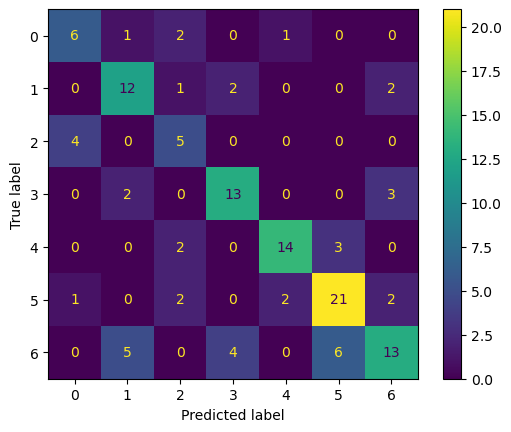

In [45]:
checkpoint = torch.load('results/efficientnetv2_s_frz0.3_drop0.5_freq_bgsup_01/best_model.pth')
import copy
best_model = copy.deepcopy(model)
best_model.load_state_dict(checkpoint) # Load weights

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)
pred_val_list = []
for i in val_loader:
    # print(i[0].shape)
    # plt.imshow(i[0][0].permute(1, 2, 0))
    best_model.eval()
    with torch.no_grad():
        pred = best_model(i[0].to(device))
        pred = np.argmax(pred.to('cpu').numpy(), axis = 1).item()
        pred_val_list.append(pred)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true=y_val, y_pred=pred_val_list))

cm = confusion_matrix(y_true=y_val, y_pred=pred_val_list)
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# checkpoint = torch.load('/content/drive/MyDrive/output/efficientnetv2_s/best_model.pth')
# # loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
# import copy
# test_model = copy.deepcopy(model)
# test_model.load_state_dict(checkpoint) # Load weights

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv')

In [ ]:
sample_sub.head()

In [ ]:
test_data, _ = read_data(sample_sub, main_path = 'test/test/')

In [ ]:
test_data = UWBDataset(test_data, _)

In [ ]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, pin_memory=True)

In [ ]:
for i in test_loader:
    print(i[0].shape)
    plt.imshow(i[0][0].permute(1, 2, 0))
    break

In [ ]:
# checkpoint = torch.load('results/efficientnetv2_s_smote_2/best_model.pth')
# import copy
# best_model = copy.deepcopy(model)
# best_model.load_state_dict(checkpoint) # Load weights

pred_list = []
for i in tqdm(test_loader):
    # print(i[0].shape)
    # plt.imshow(i[0][0].permute(1, 2, 0))
    best_model.eval()
    with torch.no_grad():
        pred = best_model(i[0].to(device))
        # print(pred)
        # break
        pred = np.argmax(pred.to('cpu').numpy(), axis = 1).item()
        pred_list.append(pred)

In [ ]:
sample_sub['class'] = pred_list

In [ ]:
sample_sub.head()

In [ ]:
sample_sub.to_csv(f'results/efficientnetv2_s_smote_2/{run_name}.csv', index = False)